# dV/dQ Analysis (Smoothed Data versus Unsmoothed Data)
This data file contains cell cycling data of a dummy cell:  the voltage, cell capacity, cycle number, and the state (whether charge, discharging, or resting).  A cell was cycled (charge, rest, and discharged) at a set current density for several hundred cycles.

It is of interest to calculate the first derivative of the cell voltage with respect to the normalized capacity for select cycle numbers throughout the cycling life of the cell. This will help identify any shifts in the peaks of interest, which can be later related to the degradation mechanisms of a cell. 

In this exercise, I outline a class for reading and analyzing the data, and I outline another class to graph the data. 
Finally, I demonstrate how data smoothing can remove noise and help the viewer more readily identify the shifts in the dV/dQ peaks. 

## Import libraries and configure formatting for plots

In [1]:
''' Adriana A. Rojas
this code outlines a class to read from a .txt file from a Maccor procedure
the units are such that Maccor reports time in hours, voltage in V, and Current in mA
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from matplotlib import rcParams
rcParams['font.family']='sans-serif'
rcParams['font.sans-serif']=['Arial']
size=10

## The following class, AnalyzeCyclingData, will read data, and filter relevant cycling data 

In [2]:
class AnalyzeCyclingData(object):
    def __init__(self,filename,headerlines):
        '''input:  filename is of type string, it indicates the name of the file for reading
                        headerlines is of type integer, it indicates the row where the header columns are located
        Read the file and store it in self.datafile'''
        self.filename=filename
        self.datafile=pd.read_csv(self.filename,header=headerlines,sep='\t')

    def getDataFile(self):
        '''returns the pd.DataFrame of the file that was read in'''
        return self.datafile

    def getQVforCycleN(self,cycleNum): #formerly known as findeachcyclewpandas
        '''input: cycleNum is of type integer
        return the capacity and voltage profiles for the charge and discharge event of the cycleNum cycle'''
        filterchargecycle=self.datafile[(self.datafile['Cyc#'] == cycleNum) & (self.datafile['State'] == 'C')]
        Qcharge=pd.to_numeric(filterchargecycle['uAmp-hr'],downcast='float',errors='coerce')/1000000     # Converts to Ah
        Vcharge=pd.to_numeric(filterchargecycle['Volts'],downcast='float',errors='coerce')
        #
        filterdischargecycle=self.datafile[(self.datafile['Cyc#'] == cycleNum) & (self.datafile['State'] == 'D')]
        Qdischarge=pd.to_numeric(filterdischargecycle['uAmp-hr'],downcast='float',errors='coerce')/1000000     # Converts to Ah
        Vdischarge=pd.to_numeric(filterdischargecycle['Volts'],downcast='float',errors='coerce')
        return Qcharge,Vcharge,Qdischarge,Vdischarge

    def getdVdQ(self,q,v): # function to calculate dv/dq
        '''input: capacity, q, and voltage, v, as type pd.Series
        output:  the calculated first derivative of dv/dq'''
        dvdq=[]
        voltage=[]
        cap=[]
        for r in range(0,len(q)-1,1):
            dq = q.iloc[r+1]-q.iloc[r]
            dv=v.iloc[r+1]-v.iloc[r]
            if dq!=0: # if dq DOES NOT equal to 0
                dvdq.append(dv/dq)
                voltage.append(v.iloc[r])
                cap.append(q.iloc[r])
        return pd.Series(dvdq), pd.Series(voltage),pd.Series(cap)

## Now create a class for graphing

In [3]:
class Graph(object):
    def __init__(self,fx,fy):
        '''input:  fx and fy are type integers--they are the dimensions of the figure'''
        self.fx=fx
        self.fy=fy
        fig=plt.figure(figsize=(fx,fy),dpi=300)
        
    def graphdvdq_cap(self,x,y,sym,clr,samp):
        plt.plot(x,y,sym,color=clr,mec='k',markersize=3,mew=0.2,markevery=1,label=samp,linewidth=1)
        plt.xlabel('Normalized Capacity',fontsize=size)
        plt.ylabel('dV/dQ (V/_)', fontsize=size)
        return

    def formatGraph(self):
        plt.tick_params(labelsize=size)
        plt.tick_params(which='major',right='on',direction='in',top='on',length=6)
        plt.tick_params(which='minor',right='on',direction='in',top='on',length=3)
        plt.legend(loc='best',fontsize=size-5,ncol=2)
        plt.tight_layout()
        return

## Define the file name and the list of colors

In [4]:
s0='Dummy_Cell_Data.txt'
#
colors=['k','slategray','navy', 'b', 'royalblue','deepskyblue','cornflowerblue','aqua','darkturquoise',
'cadetblue','mediumseagreen', 'lawngreen','lime','limegreen','forestgreen','darkgreen',
'indigo','rebeccapurple','darkorchid', 'mediumpurple','m','goldenrod','darkorange','sandybrown',
'peru','chocolate', 'saddlebrown','greenyellow','yellowgreen','olive','olivedrab','c','steelblue','coral',
'tomato', 'mediumvioletred','palevioletred','crimson','r','firebrick','darkred','maroon']

## Call the values of interest for the dvdq analysis and graph the raw data

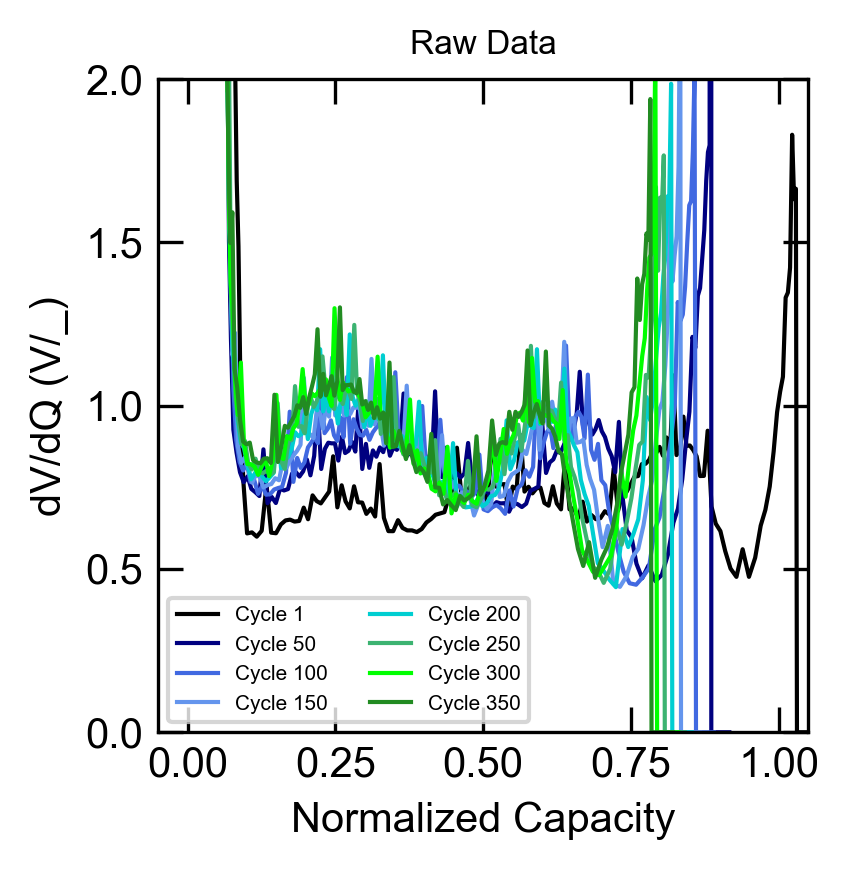

In [6]:
fig1=Graph(3,3)                             #instantiate a Graph object
data0=AnalyzeCyclingData(s0,2)              # open the data
Qc,Vc,Qd,Vd=data0.getQVforCycleN(1)         #obtain the data of interest 
FDC=Qd.iloc[-1]                             # the first discharge capacity for capacity normalization
#
count=0
#the following obtains the raw data
for num in [1]+list(range(50,400,50)):      # for each cycle number, do the following
    Qc,Vc,Qd,Vd=data0.getQVforCycleN(num)   # obtain the data of interest
    dvdq,v,cap=data0.getdVdQ(Qc/FDC,Vc)     # determine dvdq and the associated capacity
    fig1.graphdvdq_cap(cap,dvdq,'-',colors[count],'Cycle '+str(num)) # graph the results
    count+=2                                # increment count 
plt.axis([-.05,1.05,0,2])
plt.title('Raw Data',fontsize=8)
fig1.formatGraph()
plt.show()

The problem with the raw data in its present form is that it is difficult to easily observe the peak shifts along the x and y axis.  

## Call the values of interest for the dvdq analysis and **smooth** the data with a Savitzky-Golay filter

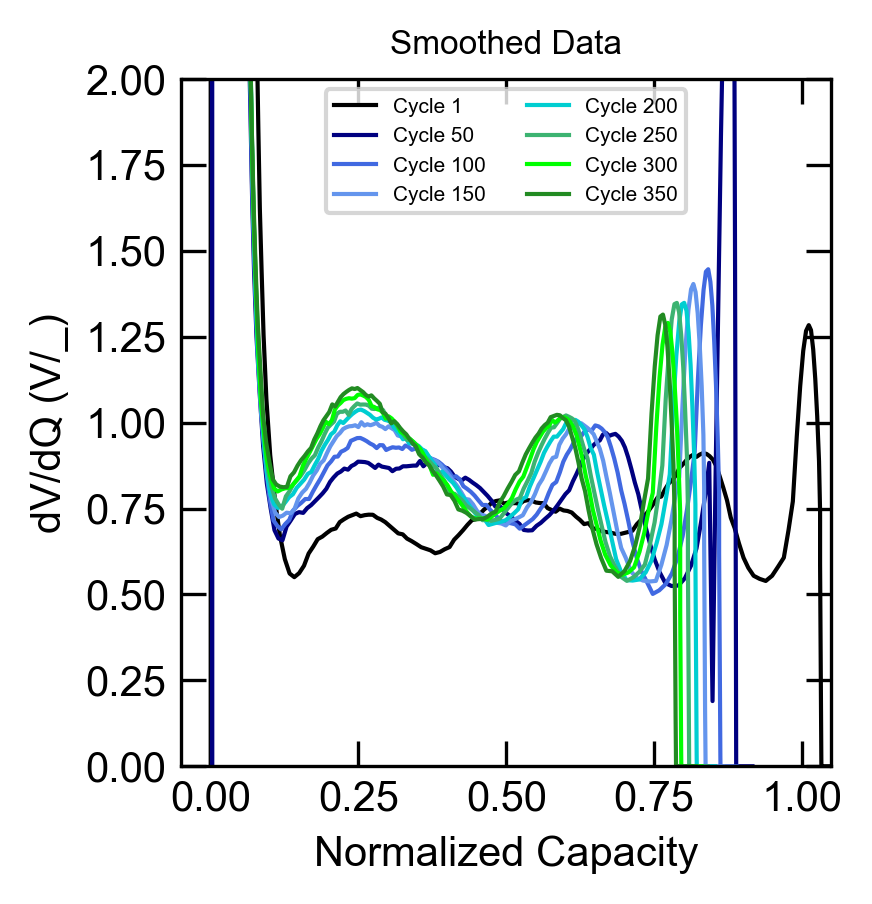

In [7]:
fig2=Graph(3,3)
count=0
# the following obtains the smoothed data
for num in [1]+list(range(50,400,50)):                # for each cycle number, do the following
    Qc,Vc,Qd,Vd=data0.getQVforCycleN(num)   # obtain the data of interest
    dvdq,v,cap=data0.getdVdQ(Qc/FDC,Vc)         # determine dvdq and the associated capacity
    dvdq_sg=savgol_filter(dvdq,21,2)                    #apply a Savitzky -Golay filter w/ window_length=21, and poly_order=2
    fig2.graphdvdq_cap(cap,dvdq_sg,'-',colors[count],'Cycle '+str(num)) # graph the results
    count+=2                                                                # increment count 
plt.axis([-.05,1.05,0,2])                                           
fig2.formatGraph()
plt.title('Smoothed Data',fontsize=8)
plt.show()

By smoothing the data, the peak shifts in the x and y directions are obvious to the viewer. 